In [5]:
import os
import numpy as np
import pandas as pd

# sacct --format="JobName%70,State,Elapsed,Start,NCPUS,NTask,AveCPU,AveRSS,MaxRSS" > report.txt

In [6]:
import re
import time
import datetime

report_file = "report_withsamples.txt"
datalist = list()

with open(report_file) as infile:
    lines = infile.readlines()
    for i in range(len(lines)):
        cline = lines[i].strip()
        if cline.startswith("compreq"):
            if lines[i+3].strip().startswith("pmi_proxy") and (lines[i+3].strip().endswith("K") or lines[i+3].strip().endswith("M")):
                pmiline = lines[i+3].strip()
                carr = cline.split()
                # Get CPU time
                jobname = carr[0]
                _cputime = time.strptime(carr[2],'%H:%M:%S')
                cputime = datetime.timedelta(hours=_cputime.tm_hour,minutes=_cputime.tm_min,seconds=_cputime.tm_sec).total_seconds()
                ncore = int(carr[4])
                # print(cputime)
                
                # Get max MEM
                parr = pmiline.split()
                _cputotal = time.strptime(parr[6],'%H:%M:%S')
                cputotal = datetime.timedelta(hours=_cputotal.tm_hour,minutes=_cputotal.tm_min,seconds=_cputotal.tm_sec).total_seconds()
                # print(cputotal, cputotal / ncore)
                maxmem = float(parr[8][:-1]) # in kilobytes
                if pmiline.endswith("M"):
                    maxmem *= 1000
                # print(maxmem)
                
                jarr = jobname.split("_")
                nsnp = int(jarr[2][3:])
                ngene = int(jarr[3][4:])
                nsamp = int(jarr[4][4:])
                print([nsnp, ngene, nsamp, cputime, maxmem])
                datalist.append([nsnp, ngene, nsamp, cputime, maxmem])

[5000, 5000, 200, 51.0, 880508.0]
[10000, 5000, 200, 63.0, 2649636.0]
[20000, 5000, 200, 86.0, 1174776.0]
[40000, 5000, 200, 135.0, 4970676.0]
[60000, 5000, 200, 193.0, 6257928.0]
[80000, 5000, 200, 267.0, 7659172.0]
[100000, 5000, 200, 341.0, 9440460.0]
[120000, 5000, 200, 429.0, 10776480.0]
[100, 10000, 200, 46.0, 778428.0]
[1000, 10000, 200, 50.0, 789728.0]
[5000, 10000, 200, 63.0, 876780.0]
[10000, 10000, 200, 83.0, 3093660.0]
[20000, 10000, 200, 109.0, 4918368.0]
[40000, 10000, 200, 167.0, 6048184.0]
[60000, 10000, 200, 223.0, 7773932.0]
[80000, 10000, 200, 296.0, 9212908.0]
[100000, 10000, 200, 375.0, 11153760.0]
[120000, 10000, 200, 481.0, 12455664.0]
[100, 15673, 200, 63.0, 884192.0]
[1000, 15673, 200, 67.0, 896500.0]
[5000, 15673, 200, 79.0, 2986376.0]
[10000, 15673, 200, 104.0, 5296624.0]
[20000, 15673, 200, 128.0, 4352084.0]
[40000, 15673, 200, 192.0, 7815020.0]
[60000, 15673, 200, 249.0, 9600204.0]
[80000, 15673, 200, 333.0, 11016048.0]
[100000, 15673, 200, 419.0, 13209432.

In [7]:
df = pd.DataFrame(np.array(datalist), columns=["NSNP", "NGENE", "NSAMP", "CPUTIME", "MAXMEM"])
df_cpu = df.pivot_table(index="NSNP", columns="NGENE", values="CPUTIME")
df_mem = df.pivot_table(index="NSNP", columns="NGENE", values="MAXMEM")
df_samp_cpu = df.pivot_table(index="NSAMP", columns="NGENE", values="CPUTIME")
df_samp_mem = df.pivot_table(index="NSAMP", columns="NGENE", values="MAXMEM")

In [8]:
df.head()

,NSNP,NGENE,NSAMP,CPUTIME,MAXMEM
0,5000.0,5000.0,200.0,51.0,880508.0
1,10000.0,5000.0,200.0,63.0,2649636.0
2,20000.0,5000.0,200.0,86.0,1174776.0
3,40000.0,5000.0,200.0,135.0,4970676.0
4,60000.0,5000.0,200.0,193.0,6257928.0


# Find out how many cismasks were used

In [9]:
import sys
#sys.path.append('../')
sys.path.append('/usr/users/fsimone/tejaas')
from iotools import readgtf
from iotools.readvcf import ReadVCF
from iotools.readRPKM import ReadRPKM
from utils.containers import GeneInfo, CisMask
from utils import cismasking

def select_donors(vcf_donors, expr_donors):
    ''' Make sure that donors are in the same order for both expression and genotype
    '''
    common_donors = [x for x in vcf_donors if x in expr_donors]
    vcfmask = np.array([vcf_donors.index(x) for x in common_donors])
    exprmask = np.array([expr_donors.index(x) for x in common_donors])
    return vcfmask, exprmask

def select_genes(info, names):
    ''' Select genes which would be analyzed. 
        Make sure the indices are not mixed up
    '''
    allowed = [x.ensembl_id for x in info]
    common  = [x for x in names if x in allowed]
    genes = [x for x in info if x.ensembl_id in common]
    indices = [names.index(x.ensembl_id) for x in genes]
    return genes, np.array(indices)

gencode_file = "/cbscratch/franco/datasets/GENCODE/gencode.v26.annotation.gtf.gz"
geneinfo = readgtf.gencode(gencode_file, biotype = ["protein_coding", "lncRNA"])

In [10]:
print("reading vcf")
vcf_file = "/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_SHAPEIT2/0.01/GTEX_v8_2020-02-21_WGS_838Indiv_Freeze.SHAPEIT2_phased_NoMissingGT_SNPfilter_MAF0.01_chr1.vcf.gz"
sample_f = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8.sample"
vcf = ReadVCF(vcf_file, 0, 2000000, samplefile=sample_f)
dosage = vcf.dosage
gt_donor_ids = vcf.donor_ids
snpinfo = vcf.snpinfo

reading vcf
GT Sample selection: 838 samples were retained from a total of 838 samples


In [11]:
print("reading expr")
# Read Gene Expression
gx_file="expr/as_tpms_qcfilter_N15673.txt"
rpkm = ReadRPKM(gx_file, "gtex")
expression = rpkm.expression
expr_donors = rpkm.donor_ids
gene_names = rpkm.gene_names

import copy
vcfmask, exprmask = select_donors(gt_donor_ids, expr_donors)
genes, indices = select_genes(geneinfo, gene_names)
dosage_masked = dosage[:, vcfmask]


reading expr


In [12]:
# Donors with GT and EXPR
gt_expr_donors = [gt_donor_ids[i] for i in vcfmask]
with open("gtex_v8_as.samples", 'w') as ostream:
    ostream.write("ID_1 ID_2 missing father mother pheno\n")
    ostream.write("0 0 0 D D B\n")
    for d in gt_expr_donors:
        ostream.write(f"{d} {d} 0 0 0 -9\n")

In [13]:
SNP_COMPLEMENT = {'A':'T', 'C':'G', 'G':'C', 'T':'A'}

def filter_snps(snpinfo, dosage):
    # Predixcan style filtering of snps
    newsnps = list()
    newdosage = list()
    npoly = 0
    nambi = 0
    nunkn = 0
    nlowf = 0
    nlowf_actual = 0
    nhwep = 0
    maf_limit = 0.01
    for i, snp in enumerate(snpinfo):
        pos = snp.bp_pos
        refAllele = snp.ref_allele
        effectAllele = snp.alt_allele
        rsid = snp.varid
        maf = round(snp.maf, 3)
        maf_actual = sum(dosage[i]) / 2 / len(dosage[i])
        # Skip non-single letter polymorphisms
        if len(refAllele) > 1 or len(effectAllele) > 1:
            npoly += 1
            continue
        # Skip ambiguous strands
        if SNP_COMPLEMENT[refAllele] == effectAllele:
            nambi += 1
            continue
        # Skip unknown RSIDs
        if rsid == '.':
            nunkn += 1
            continue
        # Skip low MAF
        if not (maf >= maf_limit and maf <= (1 - maf_limit)):
            nlowf += 1
            continue
        if not (maf_actual >= maf_limit and maf_actual <= (1 - maf_limit)):
            nlowf_actual += 1
            continue
        # if np.all(dosage[i] == dosage[i][0:]):
        #     nsame += 1
        #     continue
        # # Convert to integers 0, 1 or 2
        # bins = [0.66, 1.33]
        # intdosage = np.digitize(dosage[i], bins)
        # # Remove SNPs out of HWE
        # hwep = self.HWEcheck(intdosage)
        # if(hwep < 0.000001):
        #    nhwep += 1
        #    # self.logger.debug("SNP {:s} has a HWE p-value of {:g}".format(rsid, hwep))
        #    continue
        new_snp = snp._replace(maf = maf_actual)
        newsnps.append(new_snp)
        newdosage.append(dosage[i])
        # newdosage.append(intdosage)
    print("Removed {:d} SNPs because of non-single letter polymorphisms".format(npoly))
    print("Removed {:d} SNPs because of ambiguous strands".format(nambi))
    print("Removed {:d} SNPs because of unknown RSIDs".format(nunkn))
    print("Removed {:d} SNPs because of low MAF < {:g}".format(nlowf, maf_limit))
    print("Removed {:d} SNPs because of low MAF (current)".format(nlowf_actual))
    return newsnps, np.array(newdosage)   

snp_info, dosage = filter_snps(snpinfo, dosage_masked)

Removed 0 SNPs because of non-single letter polymorphisms
Removed 0 SNPs because of ambiguous strands
Removed 0 SNPs because of unknown RSIDs
Removed 0 SNPs because of low MAF < 0.01
Removed 13223 SNPs because of low MAF (current)


In [14]:
cismasklist = cismasking.get_cismasklist(snpinfo, geneinfo, 1, window=1e6)
cismaskcomp = cismasking.compress_cismasklist(cismasklist)

In [15]:
print(f"Number of cismask for CHR1: {len(cismaskcomp)}")

Number of cismask for CHR1: 6407


In [16]:
ncis = list()
nsnp_stack = sorted(list(set(list(df["NSNP"]))))
nsnp = int(nsnp_stack.pop(0))
for i, cismask in enumerate(cismaskcomp):
    # print(nsnp, cismask.apply2[-1], i)
    if int(nsnp) >= cismask.apply2[-1]:
        continue
        # ncis.append(i)
    else:
        while int(nsnp) <= cismask.apply2[-1]:
            ncis.append(i+1)
            print(nsnp, cismask.apply2[-1], i+1)
            print(f"push {i+1}")
            nsnp = int(nsnp_stack.pop(0))
    if len(nsnp_stack) == 0:
        j = 1
        print(cismaskcomp[i+j].apply2[-1])
        while int(nsnp) >= cismaskcomp[i+j].apply2[-1]:
            j += 1
        ncis.append(i+j)
        break
print(ncis)
snp_to_cismask = dict(zip(sorted(list(set(list(df["NSNP"])))), ncis))

100 115 15
push 15
1000 1056 29
push 29
5000 5007 114
push 114
10000 10121 201
push 201
20000 20726 269
push 269
40000 40019 532
push 532
60000 60034 767
push 767
80000 80186 1070
push 1070
100000 100128 1410
push 1410
100151
[15, 29, 114, 201, 269, 532, 767, 1070, 1410, 1690]


In [146]:
with open('chr1_snps2cismasks.txt', 'w') as outf:
    for snp in snp_to_cismask:
        outf.write(f"{int(snp)}\t{snp_to_cismask[snp]}\n")

# Make Figure

In [153]:
df.query("NGENE == 5000 & NSAMP == 200")

,NSNP,NGENE,NSAMP,CPUTIME,MAXMEM
0,5000.0,5000.0,200.0,51.0,880508.0
1,10000.0,5000.0,200.0,63.0,2649636.0
2,20000.0,5000.0,200.0,86.0,1174776.0
3,40000.0,5000.0,200.0,135.0,4970676.0
4,60000.0,5000.0,200.0,193.0,6257928.0
5,80000.0,5000.0,200.0,267.0,7659172.0
6,100000.0,5000.0,200.0,341.0,9440460.0
7,120000.0,5000.0,200.0,429.0,10776480.0


In [154]:
gene_lt

{5000.0: 'dotted', 10000.0: 'dashed', 15673.0: 'solid'}

In [155]:
sample_color

{200.0: '#DCEDFF',
 300.0: '#94B0DA',
 400.0: '#8F91A2',
 500.0: '#505A5B',
 581.0: '#343F3E'}

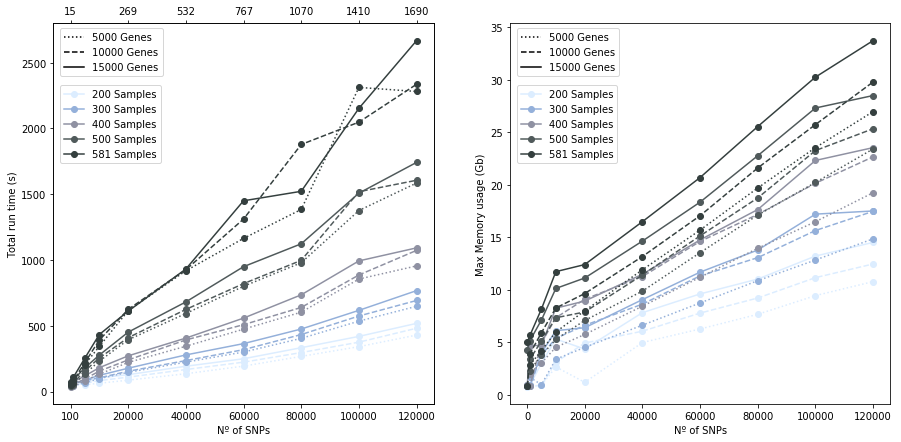

In [213]:
import matplotlib.pyplot as plt

samples = sorted(list(set(df["NSAMP"])))
snps    = sorted(list(set(df["NSNP"])))
genes   = sorted(list(set(df["NGENE"])))

gene_lt = {genes[0]: "dotted",
           genes[1]: "dashed",
           genes[2]: "solid"}

sample_color = {samples[0]: "#DCEDFF",
                samples[1]: "#94B0DA",
                samples[2]: "#8F91A2",
                samples[3]: "#505A5B",
                samples[4]: "#343F3E"}

fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
#new_df = pd.DataFrame(df_snps.values, index=list(df_snps.index), columns=list(df_snps.columns))
#print(new_df)
xlabels = list()
for sample in samples:
    for gene in genes:
        res = df.query(f"NGENE == {gene} & NSAMP == {sample}")
        x_snp = res["NSNP"]
        y_cpu = res["CPUTIME"]
        y_mem = res["MAXMEM"]
        ax1.plot(x_snp, y_cpu, marker='o', label=f"{sample}", color=sample_color[sample], linestyle=gene_lt[gene])
        ax2.plot(x_snp, y_mem/1000000, marker='o', label=f"{sample}", color=sample_color[sample], linestyle=gene_lt[gene])
        
from matplotlib.lines import Line2D        

style_legend = [Line2D([0], [0], color='black', linestyle="dotted"),
                Line2D([0], [0], color='black', linestyle="dashed"),
                Line2D([0], [0], color='black', linestyle="solid"),]    
color_legend = [Line2D([0], [0], color=sample_color[samples[0]], marker='o', linestyle="solid"),
                Line2D([0], [0], color=sample_color[samples[1]], marker='o', linestyle="solid"),
                Line2D([0], [0], color=sample_color[samples[2]], marker='o', linestyle="solid"),
                Line2D([0], [0], color=sample_color[samples[3]], marker='o', linestyle="solid"),
                Line2D([0], [0], color=sample_color[samples[4]], marker='o', linestyle="solid")] 
l11 = ax1.legend(style_legend, ['5000 Genes', '10000 Genes', '15000 Genes'], bbox_to_anchor=[0.3, 1.])
l12 = ax1.legend(color_legend, [f"{int(s)} Samples" for s in sample_color], bbox_to_anchor=[0.295, 0.85])
ax1.add_artist(l11)
l21 = ax2.legend(style_legend, ['5000 Genes', '10000 Genes', '15000 Genes'], bbox_to_anchor=[0.3, 1.])
l22 = ax2.legend(color_legend, [f"{int(s)} Samples" for s in sample_color], bbox_to_anchor=[0.295, 0.85])
ax2.add_artist(l21)

xticks = [list(x_snp)[0]] + list(x_snp)[4:]
ax1.set_xticks(xticks)
# ax1.set_xticklabels(x_labels)
# ax2.set_xticklabels(x_labels)

ax1.set_ylabel("Total run time (s)")
ax1.set_xlabel("Nº of SNPs")
ax2.set_ylabel("Max Memory usage (Gb)")
ax2.set_xlabel("Nº of SNPs")

ax11 = ax1.twiny()
ax11.set_xlim(ax1.get_xlim())
ax11.set_xticks(xticks)
ax11.set_xticklabels([snp_to_cismask[s] for s in xticks])

plt.show()


In [217]:
import matplotlib
print(matplotlib.rcParams)

_internal.classic_mode: False
agg.path.chunksize: 0
animation.avconv_args: []
animation.avconv_path: avconv
animation.bitrate: -1
animation.codec: h264
animation.convert_args: []
animation.convert_path: convert
animation.embed_limit: 20.0
animation.ffmpeg_args: []
animation.ffmpeg_path: ffmpeg
animation.frame_format: png
animation.html: none
animation.html_args: []
animation.writer: ffmpeg
axes.autolimit_mode: data
axes.axisbelow: line
axes.edgecolor: k
axes.facecolor: w
axes.formatter.limits: [-7, 7]
axes.formatter.min_exponent: 0
axes.formatter.offset_threshold: 4
axes.formatter.use_locale: False
axes.formatter.use_mathtext: False
axes.formatter.useoffset: True
axes.grid: False
axes.grid.axis: both
axes.grid.which: major
axes.hold: None
axes.labelcolor: k
axes.labelpad: 4.0
axes.labelsize: medium
axes.labelweight: normal
axes.linewidth: 0.8
axes.prop_cycle: cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])


In [201]:
ax1.get_xticks()

array([-20000.,      0.,  20000.,  40000.,  60000.,  80000., 100000.,
       120000., 140000.])

In [164]:
report_file = "report_withsamples_ncore.txt"
datalist = list()

with open(report_file) as infile:
    lines = infile.readlines()
    for i in range(len(lines)):
        cline = lines[i].strip()
        if cline.startswith("compreq"):
            if lines[i+3].strip().startswith("pmi_proxy") and (lines[i+3].strip().endswith("K") or lines[i+3].strip().endswith("M")):
                pmiline = lines[i+3].strip()
                carr = cline.split()
                # Get CPU time
                jobname = carr[0]
                _cputime = time.strptime(carr[2],'%H:%M:%S')
                cputime = datetime.timedelta(hours=_cputime.tm_hour,minutes=_cputime.tm_min,seconds=_cputime.tm_sec).total_seconds()
                ncore = int(carr[4])
                # print(cputime)
                
                # Get max MEM
                parr = pmiline.split()
                _cputotal = time.strptime(parr[6],'%H:%M:%S')
                cputotal = datetime.timedelta(hours=_cputotal.tm_hour,minutes=_cputotal.tm_min,seconds=_cputotal.tm_sec).total_seconds()
                # print(cputotal, cputotal / ncore)
                maxmem = float(parr[8][:-1]) # in kilobytes
                if pmiline.endswith("M"):
                    maxmem *= 1000
                # print(maxmem)
                
                jarr = jobname.split("_")
                nsnp = int(jarr[2][3:])
                ngene = int(jarr[3][4:])
                nsamp = int(jarr[4][4:])
                ncore = int(jarr[5][5:])
                print([nsnp, ngene, nsamp, ncore, cputime, maxmem])
                datalist.append([nsnp, ngene, nsamp, ncore, cputime, maxmem])
                
df_ncore = pd.DataFrame(np.array(datalist), columns=["NSNP", "NGENE", "NSAMP", "NCORE", "CPUTIME", "MAXMEM"])

[10000, 15673, 581, 1, 1546.0, 2531616.0]
[20000, 15673, 581, 1, 2464.0, 2765940.0]
[40000, 15673, 581, 1, 4429.0, 3933704.0]
[10000, 15673, 581, 2, 867.0, 3607452.0]
[20000, 15673, 581, 2, 1323.0, 4476844.0]
[40000, 15673, 581, 2, 2159.0, 6282104.0]
[10000, 15673, 581, 4, 483.0, 7203284.0]
[20000, 15673, 581, 4, 1095.0, 7281000.0]
[40000, 15673, 581, 4, 1361.0, 10703292.0]
[10000, 15673, 581, 8, 421.0, 11879964.0]
[20000, 15673, 581, 8, 646.0, 12832424.0]
[40000, 15673, 581, 8, 917.0, 15835140.0]
[10000, 15673, 581, 16, 411.0, 15967440.0]
[20000, 15673, 581, 16, 571.0, 21022396.0]
[40000, 15673, 581, 16, 757.0, 31305816.0]


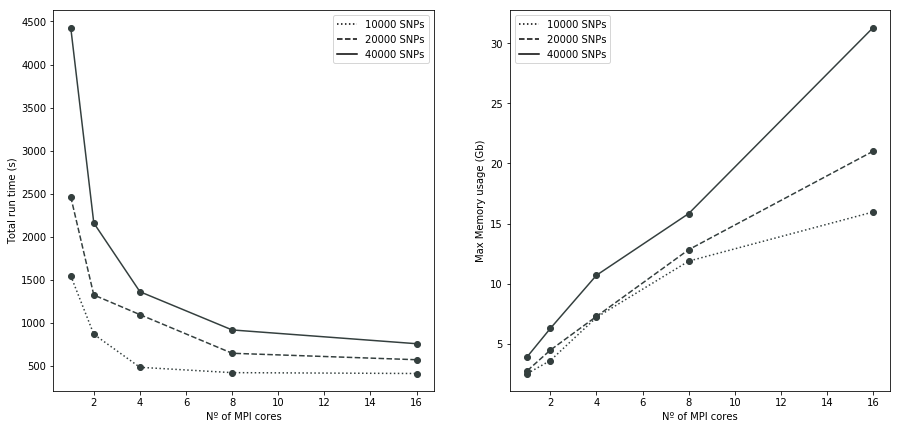

In [175]:
samples = sorted(list(set(df_ncore["NSAMP"])))
snps    = sorted(list(set(df_ncore["NSNP"])))
genes   = sorted(list(set(df_ncore["NGENE"])))
ncores  = sorted(list(set(df_ncore["NCORE"])))

snp_lt  = {snps[0]: "dotted",
           snps[1]: "dashed",
           snps[2]: "solid"}
colors = {samples[0]: "#343F3E"}

sample = samples[0]
gene   = genes[0]

fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
#new_df = pd.DataFrame(df_snps.values, index=list(df_snps.index), columns=list(df_snps.columns))
#print(new_df)
for nsnp in snps:
    res = df_ncore.query(f"NSNP == {nsnp}")
    x_ncore = res["NCORE"]
    y_cpu = res["CPUTIME"]
    y_mem = res["MAXMEM"]
    ax1.plot(x_ncore, y_cpu, marker='o', label=f"{sample}", color=colors[sample], linestyle=snp_lt[nsnp])
    ax2.plot(x_ncore, y_mem/1000000, marker='o', label=f"{sample}", color=colors[sample], linestyle=snp_lt[nsnp])
        
from matplotlib.lines import Line2D        

style_legend = [Line2D([0], [0], color='black', linestyle="dotted"),
                Line2D([0], [0], color='black', linestyle="dashed"),
                Line2D([0], [0], color='black', linestyle="solid"),]    
l11 = ax1.legend(style_legend, [f"{int(snps[0])} SNPs", f"{int(snps[1])} SNPs", f"{int(snps[2])} SNPs"], loc=1)
l21 = ax2.legend(style_legend, [f"{int(snps[0])} SNPs", f"{int(snps[1])} SNPs", f"{int(snps[2])} SNPs"], loc=2)

ax1.set_ylabel("Total run time (s)")
ax1.set_xlabel("Nº of MPI cores")
ax2.set_ylabel("Max Memory usage (Gb)")
ax2.set_xlabel("Nº of MPI cores")
plt.show()